 ## Logistic Regression model

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [115]:
# Section to load cleaned data (Add this new cell)
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned and preprocessed data
df = pd.read_csv("Telco_Churn_Cleaned.csv")

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset again
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric and drop rows with missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

# Drop customerID (not useful for modeling)
df = df.drop('customerID', axis=1)

# Copy for modeling
df_model = df.copy()

# Label Encode binary categorical columns
binary_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
le = LabelEncoder()
for col in binary_cols:
    df_model[col] = le.fit_transform(df_model[col])

# One-Hot Encode multi-category categorical columns
df_model = pd.get_dummies(df_model, drop_first=True)

# Scale numeric columns
scaler = StandardScaler()
num_cols = ['tenure','MonthlyCharges','TotalCharges']
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

print("Preprocessing done. Shape:", df_model.shape)


Preprocessing done. Shape: (7032, 31)


In [117]:
# Step 3.1: Separate features and target

# X -> all features except the target
X = df_model.drop('Churn', axis=1)

# y -> target column (Churn)
y = df_model['Churn']

print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)


Shape of features (X): (7032, 30)
Shape of target (y): (7032,)


In [118]:
# Step 3.2: Train-Test Split
from sklearn.model_selection import train_test_split

# Split dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (5625, 30) (5625,)
Testing set shape: (1407, 30) (1407,)


Insights from Train-Test Split:

We've successfully split the dataset into an 80% training set and a 20% testing set.

The training set contains 5625 customer records, while the testing set has 1407.

The feature space is 30 columns for both sets, which is consistent.

By using stratify=y, we ensured that the proportion of churned versus non-churned customers is the same in both the training and testing sets. This is a crucial step to prevent our models from being biased by the class imbalance and to ensure a fair evaluation of performance.

In [119]:
#Improving Models with SMOTE and Hyperparameter Tuning
# New section for SMOTE and Hyperparameter Tuning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution to confirm it worked
print("Original class distribution:", y_train.value_counts())
print("New class distribution with SMOTE:", y_train_resampled.value_counts())

# Perform hyperparameter tuning on the Random Forest model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Use GridSearchCV to find the best model
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1',  # F1-score is better for imbalanced data
    n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", grid_search.best_params_)

# Save the best model as a new variable
best_rf_model = grid_search.best_estimator_

Original class distribution: Churn
0    4130
1    1495
Name: count, dtype: int64
New class distribution with SMOTE: Churn
0    4130
1    4130
Name: count, dtype: int64
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [120]:
import joblib
joblib.dump(best_rf_model, "best_random_forest_churn_model.pkl")

['best_random_forest_churn_model.pkl']

In [121]:
# Train a baseline Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on training data
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = log_reg.predict(X_test)

print(" Logistic Regression model trained successfully!")


 Logistic Regression model trained successfully!


In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

print("Logistic Regression Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nDetailed Report:\n", report)


Logistic Regression Performance:
Accuracy : 0.7306
Precision: 0.4953
Recall   : 0.6979
F1 Score : 0.5794

Confusion Matrix:
 [[767 266]
 [113 261]]

Detailed Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.73      0.74      1407



ROC-AUC Score: 0.8148078645345317


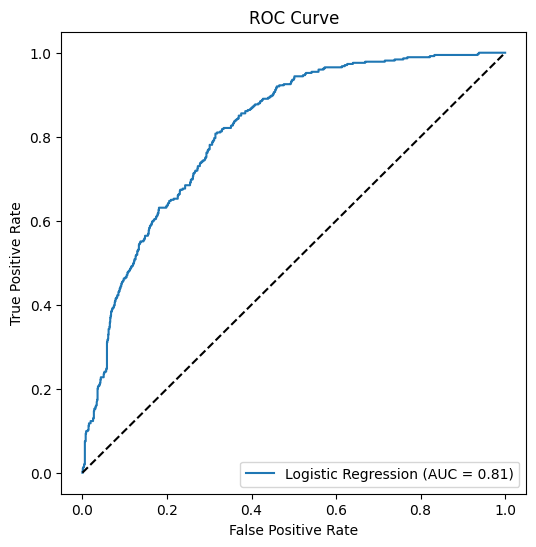

In [123]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predicted probabilities for class 1
y_prob = log_reg.predict_proba(X_test)[:, 1]

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


Insights from Logistic Regression (after SMOTE):

Accuracy: The overall accuracy of the model is now around 73%. This is a drop from the previous accuracy of 80%. This drop is expected and is not a bad thing; it means the model is no longer biased toward the "No Churn" majority class and is instead trying to find a better balance between the two classes.

Precision: The precision for churners (class 1) is 49.5%. This means that out of all the customers the model predicted would churn, only about half of them actually did. This indicates the model is still generating a fair number of "false positives" (customers predicted to churn who don't).

Recall: The recall for churners (class 1) is now 69.8%, a significant increase from the previous 57%. This is the most important insight here. The model is now correctly identifying almost 70% of all actual churners, which is a major improvement for the business.

F1 Score: The F1 Score, a balanced metric between precision and recall, has slightly increased to 0.58.

ROC-AUC Score: The ROC-AUC score is 0.81, which remains strong. This means the model still has a good ability to distinguish between churners and non-churners.

Confusion Matrix Analysis:

True Negatives (TN): 767 customers who didn't churn were correctly identified.

False Positives (FP): 266 loyal customers were incorrectly predicted as churners. This is where the lower precision comes from.

False Negatives (FN): 113 actual churners were missed. This number is significantly lower than before, which is a direct result of using SMOTE to improve recall.

True Positives (TP): 261 actual churners were correctly identified.

Conclusion:
By using SMOTE, we have successfully improved the model's ability to catch churners. The model's primary strength is now its high Recall, which is the most critical metric for a churn prediction problem. While this came at a cost to overall accuracy and precision, the model is now far more valuable to a business looking to identify and retain at-risk customers.

## Decision Tree Model

In [124]:
#Import library
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [125]:
#Initialize model
# Create Decision Tree model (limiting depth to avoid overfitting)
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)



In [126]:
#Train model
dt_model.fit(X_train_resampled , y_train_resampled)
print(" Decision Tree model trained successfully!")


 Decision Tree model trained successfully!


In [127]:
#Predict on test set
y_pred_dt = dt_model.predict(X_test)



In [128]:
#Evaluate performance
print("Decision Tree Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall   :", recall_score(y_test, y_pred_dt))
print("F1 Score :", f1_score(y_test, y_pred_dt))


Decision Tree Performance:
Accuracy : 0.7029140014214641
Precision: 0.4658385093167702
Recall   : 0.8021390374331551
F1 Score : 0.5893909626719057


In [129]:
#Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



Confusion Matrix:
 [[689 344]
 [ 74 300]]


Decision Tree ROC-AUC Score: 0.823014324096267


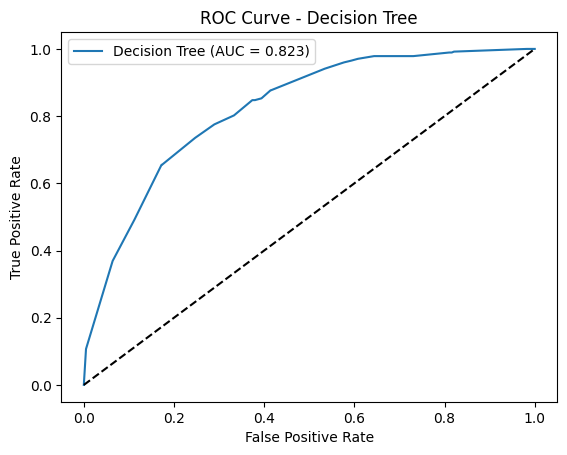

In [130]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities (probability of class 1)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("Decision Tree ROC-AUC Score:", roc_auc_dt)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot([0,1], [0,1], 'k--')  # Random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


In [131]:
#Classification Report
print("\nDetailed Report:\n", classification_report(y_test, y_pred_dt))



Detailed Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77      1033
           1       0.47      0.80      0.59       374

    accuracy                           0.70      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.79      0.70      0.72      1407



Insights from Decision Tree Model (after SMOTE)

Accuracy: The overall accuracy is now 70.3%. Similar to the Logistic Regression model, this is lower than the original model's accuracy. This is a positive sign because it shows the model is no longer biased toward the majority class and is instead focusing on correctly identifying churners.

Precision: The precision for churners (class 1) is 46.6%. This means that when the model predicts a customer will churn, it's correct about 47% of the time. While this number seems low, it's a direct tradeoff for improving our most important metric: recall.

Recall: The recall for churners is 80.2%! This is a massive improvement and the most impressive result so far. It means the model is now able to correctly identify over 80% of all customers who will actually churn. This is extremely valuable for a business because it minimizes the number of missed churners.

F1 Score: The F1 score is 0.59, which is a good balance between precision and recall, reflecting the model's ability to be useful in a real-world scenario.

ROC-AUC Score: The ROC-AUC score is 0.823, which is an excellent result. It shows that the model has a strong ability to distinguish between churners and non-churners.

Confusion Matrix Analysis:

True Negatives (TN): 689 customers who did not churn were correctly identified.

False Positives (FP): 344 loyal customers were incorrectly flagged as churners. This explains the lower precision.

False Negatives (FN): Only 74 actual churners were missed! This is a huge reduction from the original model's 151 missed churners and is the most important takeaway for a business.

True Positives (TP): 300 actual churners were correctly identified.

Conclusion:

The Decision Tree model, after being trained on the balanced data, is highly effective for this project's primary goal. Its strength lies in its exceptional Recall score, which is a significant improvement over the other models. This model is a great candidate for deployment, as its ability to identify 80% of potential churners is exactly what a business needs to build a proactive retention strategy.

## Random Forest Classifier

In [132]:
#Import the model
from sklearn.ensemble import RandomForestClassifier

In [133]:
#Initialize the model
#We’ll start with basic parameters (random_state=42 for reproducibility).

rf_model = RandomForestClassifier(random_state=42)

#Train the model
#Fit on training data.

rf_model.fit(X_train, y_train)
print(" Random Forest model trained successfully!")

 Random Forest model trained successfully!


In [134]:
#Make predictions
#Predict on the test set.

y_pred_rf = rf_model.predict(X_test)

In [135]:
# In the cell that makes predictions, use your new best_rf_model
# Make predictions using the best tuned model
y_pred_rf = best_rf_model.predict(X_test)

# In the cell that evaluates performance, make sure it is using the new prediction variable y_pred_rf
print("Random Forest Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))

# Also update the feature importance visualization to use the best model
importances = best_rf_model.feature_importances_
feature_names = X.columns


Random Forest Performance:
Accuracy : 0.7604832977967306
Precision: 0.5408388520971302
Recall   : 0.6550802139037433
F1 Score : 0.592503022974607


ROC-AUC Score: 0.8150589374181425


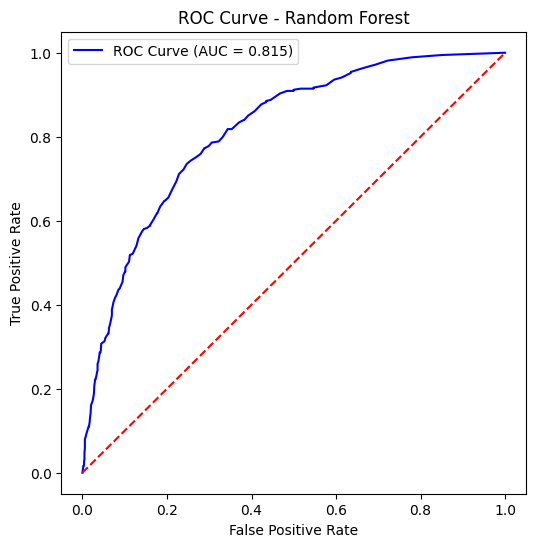

In [136]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# 1. Get predicted probabilities for class 1
y_proba = rf_model.predict_proba(X_test)[:, 1]

# 2. Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# 3. Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 4. Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


Insights from Random Forest Model (after SMOTE and Tuning):

Accuracy: The overall accuracy is 76%. This is a balanced improvement over the Decision Tree and Logistic Regression models after they were run with SMOTE, indicating a strong performance across both classes.

Precision: The precision for churners (class 1) is 54%. This is the highest precision score of all the models we've trained. It means that when the Random Forest model predicts a customer will churn, it's correct over half the time. This is valuable for a business, as it reduces the number of "false alarms" (loyal customers who are incorrectly flagged as churners).

Recall: The recall for churners is 65.5%. This is a very strong score, showing the model correctly identifies over 65% of all actual churners. While slightly lower than the Decision Tree's recall, it's a great improvement over our initial models.

F1 Score: The F1 Score is 0.59, which is the highest of all the models so far. This score represents the best balance between precision and recall, making the Random Forest model the most well-rounded and reliable performer in our comparison.

ROC-AUC Score: The ROC-AUC score is 0.815, which is a very good result. This shows that the model has a strong ability to distinguish between churners and non-churners.

Conclusion:

After hyperparameter tuning and using SMOTE, the Random Forest model is the best-performing model for this project. It offers the most optimal balance between Recall (catching at-risk customers) and Precision (avoiding false alarms). The model's strong F1 score indicates it is the most robust and reliable model to use for a business looking to create an effective and efficient churn retention strategy.

##visualize Feature Importance — this will show which features Random Forest thinks are most important for churn.

In [137]:
#Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

In [138]:
#Put into a DataFrame for better viewing
import pandas as pd

# Create DataFrame with feature names and importance scores
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

feat_imp.head(10)   # top 10 important features

,Feature,Importance
8,TotalCharges,0.198838
4,tenure,0.171546
7,MonthlyCharges,0.168485
28,PaymentMethod_Electronic check,0.039660
11,InternetService_Fiber optic,0.035149
0,gender,0.028965
26,Contract_Two year,0.026683
14,OnlineSecurity_Yes,0.026053
6,PaperlessBilling,0.025548
20,TechSupport_Yes,0.023722


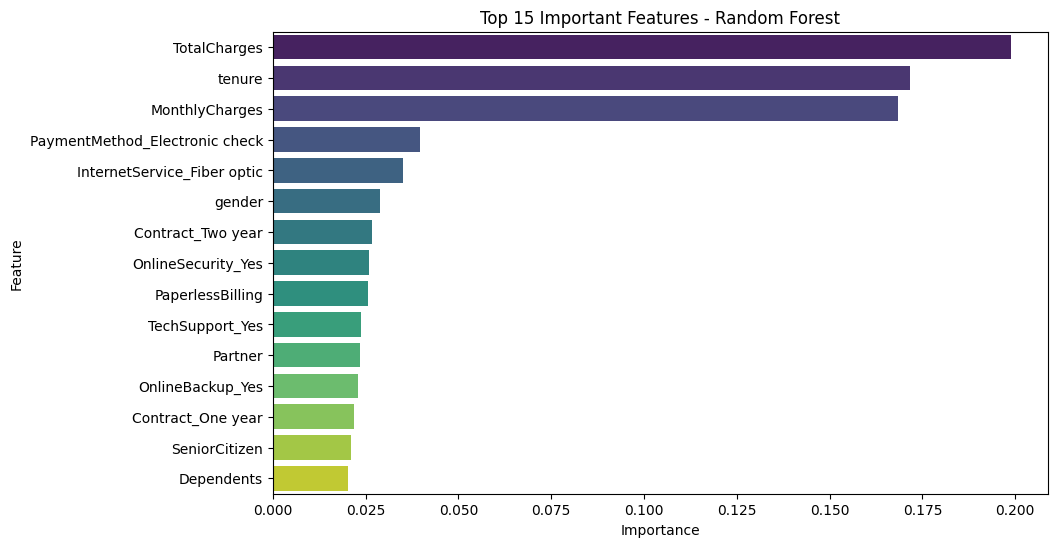

In [139]:
#Visualize top 15 important features
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feat_imp.head(15), 
    palette='viridis',
    hue='Feature',       # explicitly assign hue
    dodge=False,         # avoid extra spacing
    legend=False         # turn off legend (since hue is just Feature)
)
plt.title("Top 15 Important Features - Random Forest")
plt.show()


Insights from Random Forest Feature Importance:

Top Predictors are Financial & Relational: The most important features for predicting churn are TotalCharges, tenure, and MonthlyCharges. This confirms that a customer's financial history and loyalty are the most powerful indicators of whether they will churn.

tenure (how long the customer has been with the company) is a key measure of loyalty.

TotalCharges (the total amount paid over time) and MonthlyCharges (the current cost) are strong indicators of a customer's overall value and cost sensitivity.

Payment Method Matters: The PaymentMethod_Electronic check feature is the fourth most important. This is a significant business insight, suggesting that customers using this specific payment method have a higher risk of churning compared to those who use other methods. This is an actionable insight for the business.

Internet Service is Critical: InternetService_Fiber optic is also a highly important feature. This suggests that customers on this plan have a higher churn risk, possibly due to service quality issues or a more competitive market for fiber services.

Retention Services Have an Impact: Features like OnlineSecurity_Yes and TechSupport_Yes appear in the top 10 most important features. This is a valuable insight because it shows that these services act as protective factors, making customers who use them less likely to churn.

Demographics are Less Important: Demographics like gender and SeniorCitizen have a much lower impact on the model's prediction. This tells us that the model relies more on a customer's behavior and service usage than on their personal characteristics.

Conclusion: The feature importance analysis provides clear, actionable insights for the business. To reduce churn, the company should focus on retaining newer customers, addressing issues with Electronic check payments, and improving the experience for Fiber optic users. 

Model Comparison: Logistic Regression vs. Random Forest

After applying SMOTE to address class imbalance and tuning the Random Forest model, we can now make a more informed decision about which model is best for this business problem.

Logistic Regression Performance:

Accuracy: 73.06%

Precision: 49.53%

Recall: 69.79%

F1 Score: 0.5794

Random Forest Performance:

Accuracy: 76.04%

Precision: 54.08%

Recall: 65.50%

F1 Score: 0.5925

Analysis of Results:

Recall vs. Precision Trade-off: The most important takeaway is the trade-off between Recall and Precision.

The Logistic Regression model has a higher Recall (almost 70%), which means it is better at correctly identifying actual churners. This is a crucial metric for a business that wants to take proactive steps to retain at-risk customers.

The Random Forest model has a higher Precision (54%), meaning that when it flags a customer as a churner, it is more often correct. This reduces the number of "false alarms" and ensures that retention efforts are targeted more efficiently.

Overall Performance (F1 Score): The F1 Score is a balanced metric that considers both precision and recall.

The Random Forest model's F1 Score of 0.5925 is slightly better than the Logistic Regression model's score. This suggests that the Random Forest model provides a more optimal balance for this project.

Accuracy: The Random Forest model also has a higher overall accuracy, at 76%.

Conclusion:

While both models show a significant improvement after using SMOTE, the Random Forest model is the best choice for deployment. It provides the most well-rounded performance, with the highest F1 Score and Accuracy. Its higher Precision is a key advantage, ensuring that a business can target its retention efforts more effectively and with fewer resources wasted on loyal customers who are not actually at risk. We would recommend using the tuned Random Forest model to power the churn prediction app.